In [ ]:
#Use Monte Carlo Simulation to calculate a reasonalbe range for hiring/firing amount
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 📌 1. 读取数据
# 读取代理初始人数数据
agent_staffing = pd.read_csv("Existing Agent Staffing - data.csv")  # 文件名需修改
# 读取薪资和广告商资格阈值数据
salary_threshold = pd.read_csv("Agent Salary and Eligibility Threshold - data.csv")  # 文件名需修改
# 读取 2025 年广告商 sign-up 数据
signups_2025 = pd.read_csv("simulated_advertiser_signups_2025_daily.csv")  # 文件名需修改


In [ ]:

# 📌 2. 初始化参数
num_simulations = 1000  # Monte Carlo 运行次数
num_months = 12  # 模拟 12 个月
fire_hire_range = np.arange(-700, 700, 5)  # Fire/Hire 变化范围（每月最多 ±50 人，每次变 5）

# 存储 Net Profit 结果
profit_results = []

# 📌 3. Monte Carlo Simulation
for _ in range(num_simulations):
    # 随机选择一个国家进行模拟（也可以遍历所有国家）
    country = np.random.choice(agent_staffing["Country"])

    # 获取该国家的初始代理数、薪资、广告商阈值
    agents = agent_staffing.loc[agent_staffing["Country"] == country, "Existing_Agent_Count"].values[0]
    annual_salary = salary_threshold.loc[salary_threshold["Country"] == country, "Annual_Agent_Salary_USD"].values[0]
    eligibility_threshold = salary_threshold.loc[salary_threshold["Country"] == country, "Advertiser_Eligibility_Threshold_USD"].values[0]

    # 过滤出符合资格的广告商数据
    eligible_ads = signups_2025[(signups_2025["Country"] == country) & (signups_2025["Projected_Annual_Budget"] >= eligibility_threshold)]

    waiting_pool = 0  # 初始化 waiting pool
    total_profit = 0  # 总净利润
    max_ads_per_agent = 10  # 每个代理最多支持 10 个广告商
    support_duration = 60  # 代理支持广告商的天数

    for month in range(num_months):
        # 1️⃣ 计算该月份的广告商注册数量
        monthly_signups = eligible_ads[(eligible_ads["Sign_Up_Date"] >= f"2025-{month+1:02d}-01") &
                                       (eligible_ads["Sign_Up_Date"] < f"2025-{month+2:02d}-01")].shape[0]
        waiting_pool += monthly_signups

        # 2️⃣ 随机选择 Fire/Hire 方案
        fire_hire_decision = np.random.choice(fire_hire_range)
        agents = max(1, agents + fire_hire_decision)  # 确保代理数不小于 1

        # 3️⃣ 计算可以服务的广告商数量
        ads_served = min(waiting_pool, agents * max_ads_per_agent)
        waiting_pool -= ads_served

        # 4️⃣ 计算 Revenue（uplift 模型）
        uplift_probabilities = [0.05, 0.15, 0.25, 0.25, 0.20, 0.10]
        uplift_values = [0, 5, 10, 15, 20, 25]
        revenue = ads_served * np.random.choice(uplift_values, p=uplift_probabilities)

        # 5️⃣ 计算成本（工资 + Fire 成本）
        salary_cost = (agents * annual_salary) / 12
        fire_cost = abs(fire_hire_decision) * 0.4 * annual_salary if fire_hire_decision < 0 else 0
        total_cost = salary_cost + fire_cost

        # 6️⃣ 计算净利润
        monthly_profit = revenue - total_cost
        total_profit += monthly_profit

    # 存储模拟结果
    profit_results.append((fire_hire_decision, total_profit))

# 📌 4. 结果分析
profit_results = np.array(profit_results)
fire_hire_values, profits = profit_results[:, 0], profit_results[:, 1]



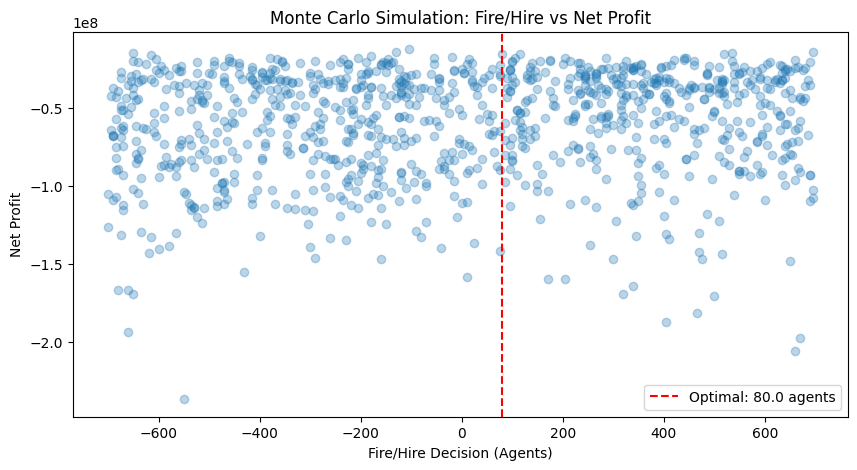

Optimal Fire/Hire range: (70.0, 90.0) agents


In [ ]:
# 计算不同 Fire/Hire 方案的平均利润
profit_summary = {}
for fire_hire in np.unique(fire_hire_values):
    profit_summary[fire_hire] = np.mean(profits[fire_hire_values == fire_hire])

# 找到最优 Fire/Hire 范围
optimal_fire_hire = max(profit_summary, key=profit_summary.get)
optimal_range = (optimal_fire_hire - 10, optimal_fire_hire + 10)

# 📌 5. 画出 Fire/Hire 方案与 Net Profit 关系
plt.figure(figsize=(10, 5))
plt.scatter(fire_hire_values, profits, alpha=0.3)
plt.xlabel("Fire/Hire Decision (Agents)")
plt.ylabel("Net Profit")
plt.title("Monte Carlo Simulation: Fire/Hire vs Net Profit")
plt.axvline(optimal_fire_hire, color='r', linestyle='--', label=f"Optimal: {optimal_fire_hire} agents")
plt.legend()
plt.show()

print(f"Optimal Fire/Hire range: {optimal_range} agents")

In [1]:
import numpy as np
import pandas as pd

# 读取数据
sim_signups = pd.read_csv("simulated_advertiser_signups_2025_daily_with_ID.csv")
agent_salary_threshold = pd.read_csv("[BADSS case] Agent Salary and Eligibility Threshold - data.csv")
existing_agent_staffing = pd.read_csv("[BADSS case] Existing Agent Staffing - data.csv")

# 预处理数据
sim_signups['Sign_Up_Date'] = pd.to_datetime(sim_signups['Sign_Up_Date'])
sim_signups['Sign_Up_Day'] = sim_signups['Sign_Up_Date'].dt.dayofyear

# 设定参数
agent_capacity_per_agent = 10  # 每个代理最多匹配 10 个广告商
advertiser_lifecycle = 60  # 60 天后广告商退出
probabilities = [0.05, 0.15, 0.25, 0.25, 0.2, 0.1]  # Uplift 概率
uplift_percentages = [0, 5, 10, 15, 20, 25]  # Uplift 百分比

# 存储最终年度结果
final_results = []

# 遍历所有国家
for country in sim_signups['Country'].unique():
    existing_agents_count = int(existing_agent_staffing[existing_agent_staffing['Country'] == country]['Existing_Agent_Count'].values[0])
    agent_annual_salary = float(agent_salary_threshold[agent_salary_threshold['Country'] == country]['Annual_Agent_Salary_USD'].values[0])

    # 初始化变量
    available_agents = existing_agents_count  # 代理数量固定，不变
    waiting_pool = 0
    total_revenue = 0
    total_cost = available_agents * (agent_annual_salary / 365) * 365  # 计算全年固定工资
    advertiser_churn = 0  # 记录流失的广告商数量

    # 每日循环
    for day in range(1, 366):
        # 📌 **广告商注册 & 进入 Waiting Pool**
        new_advertisers = sim_signups[(sim_signups['Country'] == country) & (sim_signups['Sign_Up_Day'] == day)]
        waiting_pool += len(new_advertisers)

        # 📌 **广告商匹配**
        ads_served_today = max(0, min(waiting_pool, available_agents * agent_capacity_per_agent))
        waiting_pool -= ads_served_today

        # 计算 Revenue（仅计算分配的广告商）
        if ads_served_today > 0:
            num_matched = min(ads_served_today, new_advertisers.shape[0])
            uplift = np.random.choice(uplift_percentages, size=num_matched, p=probabilities)
            revenue_today = np.sum(new_advertisers["Projected_Annual_Budget"].values[:num_matched] * uplift / 100)
            total_revenue += revenue_today

        # **移除超过 60 天未匹配的广告商（流失）**
        churned_ads = max(0, waiting_pool - (available_agents * agent_capacity_per_agent))
        advertiser_churn += churned_ads
        waiting_pool = max(0, waiting_pool - churned_ads)

    # 计算最终年度 Utilization Rate
    utilization_rate = total_revenue / (available_agents * agent_capacity_per_agent * 365) if available_agents > 0 else 0
    net_profit = total_revenue - total_cost

    # 存储最终年度结果
    final_results.append({
        'Country': country,
        'Total_Revenue': total_revenue,
        'Total_Cost': total_cost,
        'Net_Profit': net_profit,
        'Utilization_Rate': utilization_rate,
        'Advertiser_Churn': advertiser_churn
    })
    print(f"\nMetrics for {country}:")
    print(f"  Total Revenue: ${total_revenue:.2f}")
    print(f"  Total Cost: ${total_cost:.2f}")
    print(f"  Net Profit: ${net_profit:.2f}")
    print(f"  Utilization Rate: {utilization_rate:.2f}")

# 转换为 DataFrame 并显示结果
benchmark_final_results = pd.DataFrame(final_results)

# 展示最终结果
print("\Benchmark Model - Final Results:")
print(final_results)


Metrics for USA:
  Total Revenue: $393110715.14
  Total Cost: $50674092.00
  Net Profit: $342436623.14
  Utilization Rate: 165.19

Metrics for UK:
  Total Revenue: $144640761.47
  Total Cost: $30421850.00
  Net Profit: $114218911.47
  Utilization Rate: 67.28

Metrics for Germany:
  Total Revenue: $120606291.56
  Total Cost: $30899456.00
  Net Profit: $89706835.56
  Utilization Rate: 54.89

Metrics for India:
  Total Revenue: $195200851.45
  Total Cost: $6042504.00
  Net Profit: $189158347.45
  Utilization Rate: 124.95

Metrics for Brazil:
  Total Revenue: $143531301.02
  Total Cost: $5282550.00
  Net Profit: $138248751.02
  Utilization Rate: 208.06

Metrics for Japan:
  Total Revenue: $98385408.64
  Total Cost: $14714865.00
  Net Profit: $83670543.64
  Utilization Rate: 90.76

Metrics for Australia:
  Total Revenue: $63317446.82
  Total Cost: $19577250.00
  Net Profit: $43740196.82
  Utilization Rate: 38.55

Metrics for Canada:
  Total Revenue: $82750811.78
  Total Cost: $13921680.00


In [ ]:
#Optimize Action selection (Fire/Hire policy)
#1）By using utilization rate
#Fire：
##If the Waiting Pool is low but agent utilization is less than 50%, consider Fire 5-10 people.
#If the Waiting Pool is low and the utilization rate is <30%, Fire 10-30 people.
#Hire:
#If the Waiting Pool is higher than the maximum carrying capacity of the agent (10 x the number of agents), Hire 10-30 people.
#If the utilization rate is greater than 80% and the Waiting Pool continues to increase, Hire 5-10 people.
import numpy as np
import pandas as pd
import random

# Load the necessary data
sim_signups = pd.read_csv("simulated_advertiser_signups_2025_daily_with_ID.csv")
agent_salary_threshold = pd.read_csv("[BADSS case] Agent Salary and Eligibility Threshold - data.csv")
existing_agent_staffing = pd.read_csv("[BADSS case] Existing Agent Staffing - data.csv")

# Convert Sign_Up_Date to day-of-year
sim_signups['Sign_Up_Date'] = pd.to_datetime(sim_signups['Sign_Up_Date'])
sim_signups['Sign_Up_Day'] = sim_signups['Sign_Up_Date'].dt.dayofyear

# Constants
agent_capacity_per_agent = 10
advertiser_lifecycle = 60
action_space = [-30, -20, -10, 0, 10, 20, 30]  # 每月 Fire/Hire 选项
probabilities = [0.05, 0.15, 0.25, 0.25, 0.2, 0.1]  # Uplift 概率
uplift_percentages = [0, 5, 10, 15, 20, 25]  # Uplift 百分比

# Store results for final year-end comparison
final_results = []

days_in_year = 365

# Run simulation for each country separately
for country in sim_signups['Country'].unique():
    existing_agents_count = int(existing_agent_staffing[existing_agent_staffing['Country'] == country]['Existing_Agent_Count'].values[0])
    agent_annual_salary = float(agent_salary_threshold[agent_salary_threshold['Country'] == country]['Annual_Agent_Salary_USD'].values[0])

    # Initialize variables
    available_agents = existing_agents_count
    waiting_pool = 0
    total_revenue = 0
    total_cost = 0
    advertiser_churn = 0

    # Fire & Hire 队列（初始化 30 天）
    fire_queue = [0] * 30
    hire_queue = [0] * 30

    # Simulate each day
    for day in range(1, days_in_year + 1):
        # 📌 **广告商注册 & 匹配**
        new_advertisers = sim_signups[(sim_signups['Country'] == country) & (sim_signups['Sign_Up_Day'] == day)]
        waiting_pool += len(new_advertisers)

        # **确保 ads_served_today 不是负数**
        ads_served_today = max(0, min(waiting_pool, available_agents * agent_capacity_per_agent))
        waiting_pool -= ads_served_today

        # 📌 **每月月初做 Fire/Hire 决策**
        if day % 30 == 1:
            utilization = ads_served_today / (available_agents * agent_capacity_per_agent) if available_agents > 0 else 0

            if waiting_pool < available_agents * 5 and utilization < 0.5:
                action = random.choice([-10, -5, 0])  # 小幅 Fire
            elif utilization < 0.3:
                action = random.choice([-30, -20, -10])  # 大幅 Fire
            elif waiting_pool > available_agents * 10 or utilization > 0.8:
                action = random.choice([10, 20, 30])  # Hire
            else:
                action = 0  # No Action

            fire_queue.append(abs(action) if action < 0 else 0)  # Fire 1 个月后生效
            hire_queue.append(action if action > 0 else 0)  # Hire 2 个月后生效

        # 📌 **Fire & Hire 影响（延迟生效）**
        available_agents -= fire_queue.pop(0) if fire_queue else 0
        available_agents += hire_queue.pop(0) if hire_queue else 0

        # 计算 Fire 成本
        fire_cost = sum(fire_queue) * 0.4 * agent_annual_salary / 12 / 30
        total_cost += fire_cost

        # **避免 np.random.choice() 报错**
        if ads_served_today > 0: # 确保 uplift 的 size 不超过 available advertisers
           num_matched = min(ads_served_today, new_advertisers.shape[0])
           uplift = np.random.choice(uplift_percentages, size=num_matched, p=probabilities)
           revenue_today = np.sum(new_advertisers["Projected_Annual_Budget"].values[:num_matched] * uplift / 100)
           total_revenue += revenue_today



        # **广告商超过 60 天未匹配（流失）**
        churned_ids = max(0, waiting_pool - (available_agents * agent_capacity_per_agent))
        advertiser_churn += churned_ids
        waiting_pool = max(0, waiting_pool - churned_ids)  # 移除流失广告商

        # 计算总成本
        total_cost += available_agents * (agent_annual_salary / 365)

    # 计算最终年数据
    utilization_rate = total_revenue / (available_agents * agent_capacity_per_agent * days_in_year) if available_agents > 0 else 0
    net_profit = total_revenue - total_cost

    final_results.append({
        'Country': country,
        'Total_Revenue': total_revenue,
        'Total_Cost': total_cost,
        'Net_Profit': net_profit,
        'Utilization_Rate': utilization_rate
    })

# Convert to DataFrame
rule_based_final_results = pd.DataFrame(final_results)

# Display final results
print("\nSemi-MDP Rule-Based Model - Final Results:")
print(rule_based_final_results)
rule_based_final_results.to_csv("rule_based_final_results.csv", index=False)
print("Results saved to rule_based_final_results.csv")





Semi-MDP Rule-Based Model - Final Results:
         Country  Total_Revenue    Total_Cost    Net_Profit  Utilization_Rate  \
0            USA   3.932392e+08  4.808392e+07  3.451553e+08        186.718847   
1             UK   1.459022e+08  2.857364e+07  1.173286e+08         76.284760   
2        Germany   1.214264e+08  2.946462e+07  9.196176e+07         60.818100   
3          India   1.950149e+08  5.705993e+06  1.893089e+08        145.186823   
4         Brazil   1.441941e+08  4.320445e+06  1.398737e+08        318.590684   
5          Japan   9.866735e+07  1.271122e+07  8.595613e+07        121.766440   
6      Australia   6.360499e+07  1.860369e+07  4.500129e+07         43.027219   
7         Canada   8.257195e+07  1.216697e+07  7.040498e+07        143.180084   
8         France   8.002691e+07  2.902794e+07  5.099897e+07         52.959371   
9         Mexico   3.594123e+07  8.067877e+06  2.787335e+07         26.470195   
10         China   1.686987e+08  5.002305e+06  1.636964e+08      

In [8]:
# 读取数据
sim_signups = pd.read_csv("simulated_advertiser_signups_2025_daily_with_ID.csv")
agent_salary_threshold = pd.read_csv("[BADSS case] Agent Salary and Eligibility Threshold - data.csv")
existing_agent_staffing = pd.read_csv("[BADSS case] Existing Agent Staffing - data.csv")

# 预处理数据
sim_signups['Sign_Up_Date'] = pd.to_datetime(sim_signups['Sign_Up_Date'])
sim_signups['Sign_Up_Day'] = sim_signups['Sign_Up_Date'].dt.dayofyear

# 设定参数
agent_capacity_per_agent = 10  # 每个代理最多匹配 10 个广告商
advertiser_lifecycle = 60  # 60 天后广告商退出
action_space = [-30, -20, -10, 0, 10, 20, 30]  # 每月 Fire/Hire 选项

for country in sim_signups['Country'].unique():
    existing_agents_count = int(existing_agent_staffing[existing_agent_staffing['Country'] == country]['Existing_Agent_Count'].values[0])
    agent_annual_salary = float(agent_salary_threshold[agent_salary_threshold['Country'] == country]['Annual_Agent_Salary_USD'].values[0])

    # 初始化变量
    available_agents = existing_agents_count
    waiting_pool = 0
    total_revenue = 0
    total_cost = 0

    # 确保 Fire/Hire 队列初始化时有 30 天的 0，防止 pop() 报错
    fire_queue = [0] * 30
    hire_queue = [0] * 30

    # 每日循环
    for day in range(1, 366):
        # 📌 **每月月初做 Fire/Hire 决策**
        if day % 30 == 1:
            action = random.choice(action_space)  # PPO 训练后这里替换 RL 选择的 action
            fire_queue.append(abs(action) if action < 0 else 0)  # Fire 需要 1 个月后生效
            hire_queue.append(action if action > 0 else 0)  # Hire 需要 1 个月培训期

        # 📌 **Fire & Hire 影响（延迟生效）**
        available_agents -= fire_queue.pop(0) if fire_queue else 0
        available_agents += hire_queue.pop(0) if hire_queue else 0

        # 计算 Fire 成本
        fire_cost = sum(fire_queue) * 0.4 * agent_annual_salary / 12 / 30
        total_cost += fire_cost

        # 📌 **广告商注册 & 匹配**
        new_advertisers = sim_signups[(sim_signups['Country'] == country) & (sim_signups['Sign_Up_Day'] == day)]
        waiting_pool += len(new_advertisers)

        ads_served_today = min(waiting_pool, available_agents * agent_capacity_per_agent)
        waiting_pool -= ads_served_today

        # 计算 Revenue
        uplift = np.random.choice([0, 5, 10, 15, 20, 25], size=ads_served_today, p=[0.05, 0.15, 0.25, 0.25, 0.2, 0.1])
        revenue_today = np.sum(new_advertisers["Projected_Annual_Budget"].values[:ads_served_today] * uplift / 100)
        total_revenue += revenue_today

    print(f"{country} | Revenue: {total_revenue:.2f} | Net Profit: {total_revenue - total_cost:.2f}")

USA | Revenue: 393404099.56 | Net Profit: 393377328.99
UK | Revenue: 145911927.34 | Net Profit: 145894710.67
Germany | Revenue: 120380551.94 | Net Profit: 120363442.60
India | Revenue: 194602047.41 | Net Profit: 194602047.41
Brazil | Revenue: 144175798.79 | Net Profit: 144147848.79
Japan | Revenue: 97970408.65 | Net Profit: 97952242.15
Australia | Revenue: 63420227.35 | Net Profit: 63419260.58
Canada | Revenue: 82262371.12 | Net Profit: 82262371.12
France | Revenue: 80088123.17 | Net Profit: 80085943.70
Mexico | Revenue: 36515542.88 | Net Profit: 36515323.00
China | Revenue: 168174090.24 | Net Profit: 168174090.24
Italy | Revenue: 50121514.67 | Net Profit: 50121035.93
Spain | Revenue: 25710835.90 | Net Profit: 25688293.24
Poland | Revenue: 16225961.58 | Net Profit: 16212607.81
South Korea | Revenue: 36132767.52 | Net Profit: 36106772.03


ValueError: negative dimensions are not allowed

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random

# 读取数据
sim_signups = pd.read_csv("simulated_advertiser_signups_2025_daily_with_ID.csv")
agent_salary_threshold = pd.read_csv("[BADSS case] Agent Salary and Eligibility Threshold - data.csv")
existing_agent_staffing = pd.read_csv("[BADSS case] Existing Agent Staffing - data.csv")

# 预处理数据
sim_signups['Sign_Up_Date'] = pd.to_datetime(sim_signups['Sign_Up_Date'])
sim_signups['Sign_Up_Day'] = sim_signups['Sign_Up_Date'].dt.dayofyear

# 设定参数
agent_capacity_per_agent = 10
advertiser_lifecycle = 60
action_space = [-30, -20, -10, 0, 10, 20, 30]  # Fire/Hire 选项
probabilities = [0.05, 0.15, 0.25, 0.25, 0.2, 0.1]
uplift_percentages = [0, 5, 10, 15, 20, 25]

# PPO Actor-Critic 网络
class PPOActorCritic(nn.Module):
    def __init__(self, state_size, action_size):
        super(PPOActorCritic, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.actor = nn.Linear(128, action_size)
        self.critic = nn.Linear(128, 1)

    def forward(self, state):
        x = self.fc(state)
        return self.actor(x), self.critic(x)

# 训练 PPO 代理
def train_ppo(env, episodes=1000, gamma=0.99, lr=0.001, epsilon=0.2):
    state_size = 3  # Available Agents, Waiting Pool, Last Month's Net Profit
    action_size = len(action_space)
    agent = PPOActorCritic(state_size, action_size)
    optimizer = optim.Adam(agent.parameters(), lr=lr)

    for episode in range(episodes):
        state = env.reset()
        log_probs, values, rewards = [], [], []
        done = False

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_logits, value = agent(state_tensor)
            action_probs = torch.softmax(action_logits, dim=-1)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()

            log_prob = action_dist.log_prob(action)
            next_state, reward, done = env.step(action.item())

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(reward)
            state = next_state

        # 计算 PPO 损失
        R = 0
        returns = []
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32)

        log_probs = torch.stack(log_probs)
        values = torch.stack(values).squeeze()

        advantage = returns - values
        actor_loss = -torch.mean(log_probs * advantage.detach())
        critic_loss = torch.mean(advantage ** 2)
        loss = actor_loss + 0.5 * critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return agent

# 定义环境
class StaffingEnv:
    def __init__(self, country):
        self.country = country
        self.existing_agents_count = int(existing_agent_staffing[existing_agent_staffing['Country'] == country]['Existing_Agent_Count'].values[0])
        self.agent_annual_salary = float(agent_salary_threshold[agent_salary_threshold['Country'] == country]['Annual_Agent_Salary_USD'].values[0])
        self.reset()

    def reset(self):
        self.available_agents = self.existing_agents_count
        self.waiting_pool = 0
        self.total_revenue = 0
        self.total_cost = 0
        return [self.available_agents, self.waiting_pool, self.total_revenue]

    def step(self, action_idx):
        action = action_space[action_idx]

        # 执行 Fire/Hire
        self.available_agents = max(0, self.available_agents + action)

        # 计算新一天的 Revenue
        new_advertisers = sim_signups[(sim_signups['Country'] == self.country) & (sim_signups['Sign_Up_Day'] == np.random.randint(1, 366))]
        self.waiting_pool += len(new_advertisers)

        ads_served_today = max(0, min(self.waiting_pool, self.available_agents * agent_capacity_per_agent))
        self.waiting_pool -= ads_served_today

        if ads_served_today > 0:
            num_matched = min(ads_served_today, new_advertisers.shape[0])
            uplift = np.random.choice(uplift_percentages, size=num_matched, p=probabilities)
            revenue_today = np.sum(new_advertisers["Projected_Annual_Budget"].values[:num_matched] * uplift / 100)
            self.total_revenue += revenue_today

        # 计算成本
        self.total_cost += self.available_agents * (self.agent_annual_salary / 365)

        # 计算 Reward
        net_profit = self.total_revenue - self.total_cost
        reward = net_profit

        done = False  # 直到 365 天才终止
        return [self.available_agents, self.waiting_pool, net_profit], reward, done

# 运行 PPO
final_results = []
for country in sim_signups['Country'].unique():
    env = StaffingEnv(country)
    trained_agent = train_ppo(env, episodes=500)

    # 运行 365 天
    state = env.reset()
    for day in range(1, 366):
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_logits, _ = trained_agent(state_tensor)
        action_probs = torch.softmax(action_logits, dim=-1)
        action = torch.argmax(action_probs).item()
        state, _, _ = env.step(action)

    final_results.append({
        'Country': country,
        'Total_Revenue': env.total_revenue,
        'Total_Cost': env.total_cost,
        'Net_Profit': env.total_revenue - env.total_cost
    })
    print(f"\nMetrics for {country}:")
    print(f"  Total Revenue: ${env.total_revenue:.2f}")
    print(f"  Total Cost: ${env.total_cost:.2f}")
    print(f"  Net Profit: ${env.total_revenue - env.total_cost:.2f}")

# 显示最终结果
ppo_final_results = pd.DataFrame(final_results)
import ace_tools as tools
tools.display_dataframe_to_user(name="PPO RL Model Results", dataframe=ppo_final_results)


Then lets test for extreme conditions

In [2]:
# 1. market drop Benchmark
# 读取数据
sim_signups = pd.read_csv("simulated_advertiser_signups_2025_drop.csv")
agent_salary_threshold = pd.read_csv("[BADSS case] Agent Salary and Eligibility Threshold - data.csv")
existing_agent_staffing = pd.read_csv("[BADSS case] Existing Agent Staffing - data.csv")

# 预处理数据
sim_signups['Sign_Up_Date'] = pd.to_datetime(sim_signups['Sign_Up_Date'])
sim_signups['Sign_Up_Day'] = sim_signups['Sign_Up_Date'].dt.dayofyear

# 设定参数
agent_capacity_per_agent = 10  # 每个代理最多匹配 10 个广告商
advertiser_lifecycle = 60  # 60 天后广告商退出
probabilities = [0.05, 0.15, 0.25, 0.25, 0.2, 0.1]  # Uplift 概率
uplift_percentages = [0, 5, 10, 15, 20, 25]  # Uplift 百分比

# 存储最终年度结果
final_results = []

# 遍历所有国家
for country in sim_signups['Country'].unique():
    existing_agents_count = int(existing_agent_staffing[existing_agent_staffing['Country'] == country]['Existing_Agent_Count'].values[0])
    agent_annual_salary = float(agent_salary_threshold[agent_salary_threshold['Country'] == country]['Annual_Agent_Salary_USD'].values[0])

    # 初始化变量
    available_agents = existing_agents_count  # 代理数量固定，不变
    waiting_pool = 0
    total_revenue = 0
    total_cost = available_agents * (agent_annual_salary / 365) * 365  # 计算全年固定工资
    advertiser_churn = 0  # 记录流失的广告商数量

    # 每日循环
    for day in range(1, 366):
        # 📌 **广告商注册 & 进入 Waiting Pool**
        new_advertisers = sim_signups[(sim_signups['Country'] == country) & (sim_signups['Sign_Up_Day'] == day)]
        waiting_pool += len(new_advertisers)

        # 📌 **广告商匹配**
        ads_served_today = max(0, min(waiting_pool, available_agents * agent_capacity_per_agent))
        waiting_pool -= ads_served_today

        # 计算 Revenue（仅计算分配的广告商）
        if ads_served_today > 0:
            num_matched = min(ads_served_today, new_advertisers.shape[0])
            uplift = np.random.choice(uplift_percentages, size=num_matched, p=probabilities)
            revenue_today = np.sum(new_advertisers["Projected_Annual_Budget"].values[:num_matched] * uplift / 100)
            total_revenue += revenue_today

        # **移除超过 60 天未匹配的广告商（流失）**
        churned_ads = max(0, waiting_pool - (available_agents * agent_capacity_per_agent))
        advertiser_churn += churned_ads
        waiting_pool = max(0, waiting_pool - churned_ads)

    # 计算最终年度 Utilization Rate
    utilization_rate = total_revenue / (available_agents * agent_capacity_per_agent * 365) if available_agents > 0 else 0
    net_profit = total_revenue - total_cost

    # 存储最终年度结果
    final_results.append({
        'Country': country,
        'Total_Revenue': total_revenue,
        'Total_Cost': total_cost,
        'Net_Profit': net_profit,
        'Utilization_Rate': utilization_rate,
        'Advertiser_Churn': advertiser_churn
    })
    print(f"\nMetrics for {country}:")
    print(f"  Total Revenue: ${total_revenue:.2f}")
    print(f"  Total Cost: ${total_cost:.2f}")
    print(f"  Net Profit: ${net_profit:.2f}")
    print(f"  Utilization Rate: {utilization_rate:.2f}")

# 转换为 DataFrame 并显示结果
benchmark_final_results = pd.DataFrame(final_results)

# 展示最终结果
print("\Benchmark Model - Final Results:")
print(final_results)


Metrics for USA:
  Total Revenue: $395139597.22
  Total Cost: $50674092.00
  Net Profit: $344465505.22
  Utilization Rate: 166.04

Metrics for UK:
  Total Revenue: $143917592.35
  Total Cost: $30421850.00
  Net Profit: $113495742.35
  Utilization Rate: 66.94

Metrics for Germany:
  Total Revenue: $118137652.28
  Total Cost: $30899456.00
  Net Profit: $87238196.28
  Utilization Rate: 53.76

Metrics for India:
  Total Revenue: $197737432.18
  Total Cost: $6042504.00
  Net Profit: $191694928.18
  Utilization Rate: 126.58

Metrics for Brazil:
  Total Revenue: $144942572.89
  Total Cost: $5282550.00
  Net Profit: $139660022.89
  Utilization Rate: 210.11

Metrics for Japan:
  Total Revenue: $98849066.48
  Total Cost: $14714865.00
  Net Profit: $84134201.48
  Utilization Rate: 91.18

Metrics for Australia:
  Total Revenue: $64299972.87
  Total Cost: $19577250.00
  Net Profit: $44722722.87
  Utilization Rate: 39.15

Metrics for Canada:
  Total Revenue: $81690556.77
  Total Cost: $13921680.00


In [3]:
#1. market drop Semi_MDP + Utilization rate
import numpy as np
import pandas as pd
import random

# Load the necessary data
sim_signups = pd.read_csv("simulated_advertiser_signups_2025_drop.csv")
agent_salary_threshold = pd.read_csv("[BADSS case] Agent Salary and Eligibility Threshold - data.csv")
existing_agent_staffing = pd.read_csv("[BADSS case] Existing Agent Staffing - data.csv")

# Convert Sign_Up_Date to day-of-year
sim_signups['Sign_Up_Date'] = pd.to_datetime(sim_signups['Sign_Up_Date'])
sim_signups['Sign_Up_Day'] = sim_signups['Sign_Up_Date'].dt.dayofyear

# Constants
agent_capacity_per_agent = 10
advertiser_lifecycle = 60
action_space = [-30, -20, -10, 0, 10, 20, 30]  # 每月 Fire/Hire 选项
probabilities = [0.05, 0.15, 0.25, 0.25, 0.2, 0.1]  # Uplift 概率
uplift_percentages = [0, 5, 10, 15, 20, 25]  # Uplift 百分比

# Store results for final year-end comparison
final_results = []

days_in_year = 365

# Run simulation for each country separately
for country in sim_signups['Country'].unique():
    existing_agents_count = int(existing_agent_staffing[existing_agent_staffing['Country'] == country]['Existing_Agent_Count'].values[0])
    agent_annual_salary = float(agent_salary_threshold[agent_salary_threshold['Country'] == country]['Annual_Agent_Salary_USD'].values[0])

    # Initialize variables
    available_agents = existing_agents_count
    waiting_pool = 0
    total_revenue = 0
    total_cost = 0
    advertiser_churn = 0

    # Fire & Hire 队列（初始化 30 天）
    fire_queue = [0] * 30
    hire_queue = [0] * 30

    # Simulate each day
    for day in range(1, days_in_year + 1):
        # 📌 **广告商注册 & 匹配**
        new_advertisers = sim_signups[(sim_signups['Country'] == country) & (sim_signups['Sign_Up_Day'] == day)]
        waiting_pool += len(new_advertisers)

        # **确保 ads_served_today 不是负数**
        ads_served_today = max(0, min(waiting_pool, available_agents * agent_capacity_per_agent))
        waiting_pool -= ads_served_today

        # 📌 **每月月初做 Fire/Hire 决策**
        if day % 30 == 1:
            utilization = ads_served_today / (available_agents * agent_capacity_per_agent) if available_agents > 0 else 0

            if waiting_pool < available_agents * 5 and utilization < 0.5:
                action = random.choice([-10, -5, 0])  # 小幅 Fire
            elif utilization < 0.3:
                action = random.choice([-30, -20, -10])  # 大幅 Fire
            elif waiting_pool > available_agents * 10 or utilization > 0.8:
                action = random.choice([10, 20, 30])  # Hire
            else:
                action = 0  # No Action

            fire_queue.append(abs(action) if action < 0 else 0)  # Fire 1 个月后生效
            hire_queue.append(action if action > 0 else 0)  # Hire 2 个月后生效

        # 📌 **Fire & Hire 影响（延迟生效）**
        available_agents -= fire_queue.pop(0) if fire_queue else 0
        available_agents += hire_queue.pop(0) if hire_queue else 0

        # 计算 Fire 成本
        fire_cost = sum(fire_queue) * 0.4 * agent_annual_salary / 12 / 30
        total_cost += fire_cost

        # **避免 np.random.choice() 报错**
        if ads_served_today > 0: # 确保 uplift 的 size 不超过 available advertisers
           num_matched = min(ads_served_today, new_advertisers.shape[0])
           uplift = np.random.choice(uplift_percentages, size=num_matched, p=probabilities)
           revenue_today = np.sum(new_advertisers["Projected_Annual_Budget"].values[:num_matched] * uplift / 100)
           total_revenue += revenue_today



        # **广告商超过 60 天未匹配（流失）**
        churned_ids = max(0, waiting_pool - (available_agents * agent_capacity_per_agent))
        advertiser_churn += churned_ids
        waiting_pool = max(0, waiting_pool - churned_ids)  # 移除流失广告商

        # 计算总成本
        total_cost += available_agents * (agent_annual_salary / 365)

    # 计算最终年数据
    utilization_rate = total_revenue / (available_agents * agent_capacity_per_agent * days_in_year) if available_agents > 0 else 0
    net_profit = total_revenue - total_cost

    final_results.append({
        'Country': country,
        'Total_Revenue': total_revenue,
        'Total_Cost': total_cost,
        'Net_Profit': net_profit,
        'Utilization_Rate': utilization_rate
    })

# Convert to DataFrame
rule_based_final_results = pd.DataFrame(final_results)

# Display final results
print("\nSemi-MDP Rule-Based Model - Final Results:")
print(rule_based_final_results)
rule_based_final_results.to_csv("rule_based_final_results.csv", index=False)
print("Results saved to rule_based_final_results.csv")





Semi-MDP Rule-Based Model - Final Results:
         Country  Total_Revenue    Total_Cost    Net_Profit  Utilization_Rate
0            USA   3.939462e+08  4.821087e+07  3.457353e+08        183.867924
1             UK   1.442349e+08  2.825732e+07  1.159776e+08         78.405584
2        Germany   1.188319e+08  2.888454e+07  8.994737e+07         61.196781
3          India   1.977495e+08  5.521169e+06  1.922284e+08        155.683786
4         Brazil   1.434996e+08  4.480168e+06  1.390194e+08        360.687711
5          Japan   9.780590e+07  1.241893e+07  8.538698e+07        123.484503
6      Australia   6.391287e+07  1.781663e+07  4.609624e+07         46.079939
7         Canada   8.064188e+07  1.274648e+07  6.789539e+07        127.709045
8         France   7.992579e+07  3.047826e+07  4.944752e+07         49.880355
9         Mexico   3.770201e+07  8.232269e+06  2.946974e+07         26.350299
10         China   1.712193e+08  4.591209e+06  1.666281e+08        257.743944
11         Italy   5

In [4]:
# 2. q4 surge Benchmark
# 读取数据
sim_signups = pd.read_csv("simulated_advertiser_signups_2025_q4_surge.csv")
agent_salary_threshold = pd.read_csv("[BADSS case] Agent Salary and Eligibility Threshold - data.csv")
existing_agent_staffing = pd.read_csv("[BADSS case] Existing Agent Staffing - data.csv")

# 预处理数据
sim_signups['Sign_Up_Date'] = pd.to_datetime(sim_signups['Sign_Up_Date'])
sim_signups['Sign_Up_Day'] = sim_signups['Sign_Up_Date'].dt.dayofyear

# 设定参数
agent_capacity_per_agent = 10  # 每个代理最多匹配 10 个广告商
advertiser_lifecycle = 60  # 60 天后广告商退出
probabilities = [0.05, 0.15, 0.25, 0.25, 0.2, 0.1]  # Uplift 概率
uplift_percentages = [0, 5, 10, 15, 20, 25]  # Uplift 百分比

# 存储最终年度结果
final_results = []

# 遍历所有国家
for country in sim_signups['Country'].unique():
    existing_agents_count = int(existing_agent_staffing[existing_agent_staffing['Country'] == country]['Existing_Agent_Count'].values[0])
    agent_annual_salary = float(agent_salary_threshold[agent_salary_threshold['Country'] == country]['Annual_Agent_Salary_USD'].values[0])

    # 初始化变量
    available_agents = existing_agents_count  # 代理数量固定，不变
    waiting_pool = 0
    total_revenue = 0
    total_cost = available_agents * (agent_annual_salary / 365) * 365  # 计算全年固定工资
    advertiser_churn = 0  # 记录流失的广告商数量

    # 每日循环
    for day in range(1, 366):
        # 📌 **广告商注册 & 进入 Waiting Pool**
        new_advertisers = sim_signups[(sim_signups['Country'] == country) & (sim_signups['Sign_Up_Day'] == day)]
        waiting_pool += len(new_advertisers)

        # 📌 **广告商匹配**
        ads_served_today = max(0, min(waiting_pool, available_agents * agent_capacity_per_agent))
        waiting_pool -= ads_served_today

        # 计算 Revenue（仅计算分配的广告商）
        if ads_served_today > 0:
            num_matched = min(ads_served_today, new_advertisers.shape[0])
            uplift = np.random.choice(uplift_percentages, size=num_matched, p=probabilities)
            revenue_today = np.sum(new_advertisers["Projected_Annual_Budget"].values[:num_matched] * uplift / 100)
            total_revenue += revenue_today

        # **移除超过 60 天未匹配的广告商（流失）**
        churned_ads = max(0, waiting_pool - (available_agents * agent_capacity_per_agent))
        advertiser_churn += churned_ads
        waiting_pool = max(0, waiting_pool - churned_ads)

    # 计算最终年度 Utilization Rate
    utilization_rate = total_revenue / (available_agents * agent_capacity_per_agent * 365) if available_agents > 0 else 0
    net_profit = total_revenue - total_cost

    # 存储最终年度结果
    final_results.append({
        'Country': country,
        'Total_Revenue': total_revenue,
        'Total_Cost': total_cost,
        'Net_Profit': net_profit,
        'Utilization_Rate': utilization_rate,
        'Advertiser_Churn': advertiser_churn
    })
    print(f"\nMetrics for {country}:")
    print(f"  Total Revenue: ${total_revenue:.2f}")
    print(f"  Total Cost: ${total_cost:.2f}")
    print(f"  Net Profit: ${net_profit:.2f}")
    print(f"  Utilization Rate: {utilization_rate:.2f}")

# 转换为 DataFrame 并显示结果
benchmark_final_results = pd.DataFrame(final_results)

# 展示最终结果
print("\Benchmark Model - Final Results:")
print(final_results)


Metrics for USA:
  Total Revenue: $388490410.85
  Total Cost: $50674092.00
  Net Profit: $337816318.85
  Utilization Rate: 163.24

Metrics for UK:
  Total Revenue: $144037085.40
  Total Cost: $30421850.00
  Net Profit: $113615235.40
  Utilization Rate: 67.00

Metrics for Germany:
  Total Revenue: $117143526.91
  Total Cost: $30899456.00
  Net Profit: $86244070.91
  Utilization Rate: 53.31

Metrics for India:
  Total Revenue: $198868162.65
  Total Cost: $6042504.00
  Net Profit: $192825658.65
  Utilization Rate: 127.30

Metrics for Brazil:
  Total Revenue: $143728862.32
  Total Cost: $5282550.00
  Net Profit: $138446312.32
  Utilization Rate: 208.35

Metrics for Japan:
  Total Revenue: $99161224.87
  Total Cost: $14714865.00
  Net Profit: $84446359.87
  Utilization Rate: 91.47

Metrics for Australia:
  Total Revenue: $63978524.05
  Total Cost: $19577250.00
  Net Profit: $44401274.05
  Utilization Rate: 38.95

Metrics for Canada:
  Total Revenue: $81463089.38
  Total Cost: $13921680.00


In [5]:
#2. q4 surge Semi_MDP + Utilization rate
import numpy as np
import pandas as pd
import random

# Load the necessary data
sim_signups = pd.read_csv("simulated_advertiser_signups_2025_q4_surge.csv")
agent_salary_threshold = pd.read_csv("[BADSS case] Agent Salary and Eligibility Threshold - data.csv")
existing_agent_staffing = pd.read_csv("[BADSS case] Existing Agent Staffing - data.csv")

# Convert Sign_Up_Date to day-of-year
sim_signups['Sign_Up_Date'] = pd.to_datetime(sim_signups['Sign_Up_Date'])
sim_signups['Sign_Up_Day'] = sim_signups['Sign_Up_Date'].dt.dayofyear

# Constants
agent_capacity_per_agent = 10
advertiser_lifecycle = 60
action_space = [-30, -20, -10, 0, 10, 20, 30]  # 每月 Fire/Hire 选项
probabilities = [0.05, 0.15, 0.25, 0.25, 0.2, 0.1]  # Uplift 概率
uplift_percentages = [0, 5, 10, 15, 20, 25]  # Uplift 百分比

# Store results for final year-end comparison
final_results = []

days_in_year = 365

# Run simulation for each country separately
for country in sim_signups['Country'].unique():
    existing_agents_count = int(existing_agent_staffing[existing_agent_staffing['Country'] == country]['Existing_Agent_Count'].values[0])
    agent_annual_salary = float(agent_salary_threshold[agent_salary_threshold['Country'] == country]['Annual_Agent_Salary_USD'].values[0])

    # Initialize variables
    available_agents = existing_agents_count
    waiting_pool = 0
    total_revenue = 0
    total_cost = 0
    advertiser_churn = 0

    # Fire & Hire 队列（初始化 30 天）
    fire_queue = [0] * 30
    hire_queue = [0] * 30

    # Simulate each day
    for day in range(1, days_in_year + 1):
        # 📌 **广告商注册 & 匹配**
        new_advertisers = sim_signups[(sim_signups['Country'] == country) & (sim_signups['Sign_Up_Day'] == day)]
        waiting_pool += len(new_advertisers)

        # **确保 ads_served_today 不是负数**
        ads_served_today = max(0, min(waiting_pool, available_agents * agent_capacity_per_agent))
        waiting_pool -= ads_served_today

        # 📌 **每月月初做 Fire/Hire 决策**
        if day % 30 == 1:
            utilization = ads_served_today / (available_agents * agent_capacity_per_agent) if available_agents > 0 else 0

            if waiting_pool < available_agents * 5 and utilization < 0.5:
                action = random.choice([-10, -5, 0])  # 小幅 Fire
            elif utilization < 0.3:
                action = random.choice([-30, -20, -10])  # 大幅 Fire
            elif waiting_pool > available_agents * 10 or utilization > 0.8:
                action = random.choice([10, 20, 30])  # Hire
            else:
                action = 0  # No Action

            fire_queue.append(abs(action) if action < 0 else 0)  # Fire 1 个月后生效
            hire_queue.append(action if action > 0 else 0)  # Hire 2 个月后生效

        # 📌 **Fire & Hire 影响（延迟生效）**
        available_agents -= fire_queue.pop(0) if fire_queue else 0
        available_agents += hire_queue.pop(0) if hire_queue else 0

        # 计算 Fire 成本
        fire_cost = sum(fire_queue) * 0.4 * agent_annual_salary / 12 / 30
        total_cost += fire_cost

        # **避免 np.random.choice() 报错**
        if ads_served_today > 0: # 确保 uplift 的 size 不超过 available advertisers
           num_matched = min(ads_served_today, new_advertisers.shape[0])
           uplift = np.random.choice(uplift_percentages, size=num_matched, p=probabilities)
           revenue_today = np.sum(new_advertisers["Projected_Annual_Budget"].values[:num_matched] * uplift / 100)
           total_revenue += revenue_today



        # **广告商超过 60 天未匹配（流失）**
        churned_ids = max(0, waiting_pool - (available_agents * agent_capacity_per_agent))
        advertiser_churn += churned_ids
        waiting_pool = max(0, waiting_pool - churned_ids)  # 移除流失广告商

        # 计算总成本
        total_cost += available_agents * (agent_annual_salary / 365)

    # 计算最终年数据
    utilization_rate = total_revenue / (available_agents * agent_capacity_per_agent * days_in_year) if available_agents > 0 else 0
    net_profit = total_revenue - total_cost

    final_results.append({
        'Country': country,
        'Total_Revenue': total_revenue,
        'Total_Cost': total_cost,
        'Net_Profit': net_profit,
        'Utilization_Rate': utilization_rate
    })

# Convert to DataFrame
rule_based_final_results = pd.DataFrame(final_results)

# Display final results
print("\nSemi-MDP Rule-Based Model - Final Results:")
print(rule_based_final_results)
rule_based_final_results.to_csv("rule_based_final_results.csv", index=False)
print("Results saved to rule_based_final_results.csv")





Semi-MDP Rule-Based Model - Final Results:
         Country  Total_Revenue    Total_Cost    Net_Profit  Utilization_Rate
0            USA   3.889078e+08  4.870595e+07  3.402018e+08        176.993478
1             UK   1.454464e+08  2.919881e+07  1.162476e+08         73.930127
2        Germany   1.168507e+08  2.913109e+07  8.771960e+07         60.176477
3          India   2.000415e+08  5.535108e+06  1.945064e+08        155.257475
4         Brazil   1.430078e+08  4.492739e+06  1.385150e+08        315.969454
5          Japan   9.950544e+07  1.397508e+07  8.553036e+07        106.076906
6      Australia   6.303391e+07  1.846494e+07  4.456897e+07         43.173910
7         Canada   8.092218e+07  1.203131e+07  6.889087e+07        128.152954
8         France   8.156660e+07  2.967926e+07  5.188734e+07         52.705218
9         Mexico   3.750832e+07  8.135829e+06  2.937250e+07         27.257967
10         China   1.690973e+08  4.644584e+06  1.644527e+08        261.740235
11         Italy   4

In [6]:
# 3. market recovery Benchmark
# 读取数据
sim_signups = pd.read_csv("simulated_advertiser_signups_2025_market_recovery.csv")
agent_salary_threshold = pd.read_csv("[BADSS case] Agent Salary and Eligibility Threshold - data.csv")
existing_agent_staffing = pd.read_csv("[BADSS case] Existing Agent Staffing - data.csv")

# 预处理数据
sim_signups['Sign_Up_Date'] = pd.to_datetime(sim_signups['Sign_Up_Date'])
sim_signups['Sign_Up_Day'] = sim_signups['Sign_Up_Date'].dt.dayofyear

# 设定参数
agent_capacity_per_agent = 10  # 每个代理最多匹配 10 个广告商
advertiser_lifecycle = 60  # 60 天后广告商退出
probabilities = [0.05, 0.15, 0.25, 0.25, 0.2, 0.1]  # Uplift 概率
uplift_percentages = [0, 5, 10, 15, 20, 25]  # Uplift 百分比

# 存储最终年度结果
final_results = []

# 遍历所有国家
for country in sim_signups['Country'].unique():
    existing_agents_count = int(existing_agent_staffing[existing_agent_staffing['Country'] == country]['Existing_Agent_Count'].values[0])
    agent_annual_salary = float(agent_salary_threshold[agent_salary_threshold['Country'] == country]['Annual_Agent_Salary_USD'].values[0])

    # 初始化变量
    available_agents = existing_agents_count  # 代理数量固定，不变
    waiting_pool = 0
    total_revenue = 0
    total_cost = available_agents * (agent_annual_salary / 365) * 365  # 计算全年固定工资
    advertiser_churn = 0  # 记录流失的广告商数量

    # 每日循环
    for day in range(1, 366):
        # 📌 **广告商注册 & 进入 Waiting Pool**
        new_advertisers = sim_signups[(sim_signups['Country'] == country) & (sim_signups['Sign_Up_Day'] == day)]
        waiting_pool += len(new_advertisers)

        # 📌 **广告商匹配**
        ads_served_today = max(0, min(waiting_pool, available_agents * agent_capacity_per_agent))
        waiting_pool -= ads_served_today

        # 计算 Revenue（仅计算分配的广告商）
        if ads_served_today > 0:
            num_matched = min(ads_served_today, new_advertisers.shape[0])
            uplift = np.random.choice(uplift_percentages, size=num_matched, p=probabilities)
            revenue_today = np.sum(new_advertisers["Projected_Annual_Budget"].values[:num_matched] * uplift / 100)
            total_revenue += revenue_today

        # **移除超过 60 天未匹配的广告商（流失）**
        churned_ads = max(0, waiting_pool - (available_agents * agent_capacity_per_agent))
        advertiser_churn += churned_ads
        waiting_pool = max(0, waiting_pool - churned_ads)

    # 计算最终年度 Utilization Rate
    utilization_rate = total_revenue / (available_agents * agent_capacity_per_agent * 365) if available_agents > 0 else 0
    net_profit = total_revenue - total_cost

    # 存储最终年度结果
    final_results.append({
        'Country': country,
        'Total_Revenue': total_revenue,
        'Total_Cost': total_cost,
        'Net_Profit': net_profit,
        'Utilization_Rate': utilization_rate,
        'Advertiser_Churn': advertiser_churn
    })
    print(f"\nMetrics for {country}:")
    print(f"  Total Revenue: ${total_revenue:.2f}")
    print(f"  Total Cost: ${total_cost:.2f}")
    print(f"  Net Profit: ${net_profit:.2f}")
    print(f"  Utilization Rate: {utilization_rate:.2f}")

# 转换为 DataFrame 并显示结果
benchmark_final_results = pd.DataFrame(final_results)

# 展示最终结果
print("\Benchmark Model - Final Results:")
print(final_results)


Metrics for USA:
  Total Revenue: $590267939.90
  Total Cost: $50674092.00
  Net Profit: $539593847.90
  Utilization Rate: 248.03

Metrics for UK:
  Total Revenue: $216540711.17
  Total Cost: $30421850.00
  Net Profit: $186118861.17
  Utilization Rate: 100.72

Metrics for Germany:
  Total Revenue: $181919428.83
  Total Cost: $30899456.00
  Net Profit: $151019972.83
  Utilization Rate: 82.79

Metrics for India:
  Total Revenue: $296048995.63
  Total Cost: $6042504.00
  Net Profit: $290006491.63
  Utilization Rate: 189.51

Metrics for Brazil:
  Total Revenue: $215252209.72
  Total Cost: $5282550.00
  Net Profit: $209969659.72
  Utilization Rate: 312.03

Metrics for Japan:
  Total Revenue: $147948785.58
  Total Cost: $14714865.00
  Net Profit: $133233920.58
  Utilization Rate: 136.48

Metrics for Australia:
  Total Revenue: $95251029.92
  Total Cost: $19577250.00
  Net Profit: $75673779.92
  Utilization Rate: 57.99

Metrics for Canada:
  Total Revenue: $121434533.79
  Total Cost: $139216

In [7]:
#3. market recovery Semi_MDP + Utilization rate
import numpy as np
import pandas as pd
import random

# Load the necessary data
sim_signups = pd.read_csv("simulated_advertiser_signups_2025_market_recovery.csv")
agent_salary_threshold = pd.read_csv("[BADSS case] Agent Salary and Eligibility Threshold - data.csv")
existing_agent_staffing = pd.read_csv("[BADSS case] Existing Agent Staffing - data.csv")

# Convert Sign_Up_Date to day-of-year
sim_signups['Sign_Up_Date'] = pd.to_datetime(sim_signups['Sign_Up_Date'])
sim_signups['Sign_Up_Day'] = sim_signups['Sign_Up_Date'].dt.dayofyear

# Constants
agent_capacity_per_agent = 10
advertiser_lifecycle = 60
action_space = [-30, -20, -10, 0, 10, 20, 30]  # 每月 Fire/Hire 选项
probabilities = [0.05, 0.15, 0.25, 0.25, 0.2, 0.1]  # Uplift 概率
uplift_percentages = [0, 5, 10, 15, 20, 25]  # Uplift 百分比

# Store results for final year-end comparison
final_results = []

days_in_year = 365

# Run simulation for each country separately
for country in sim_signups['Country'].unique():
    existing_agents_count = int(existing_agent_staffing[existing_agent_staffing['Country'] == country]['Existing_Agent_Count'].values[0])
    agent_annual_salary = float(agent_salary_threshold[agent_salary_threshold['Country'] == country]['Annual_Agent_Salary_USD'].values[0])

    # Initialize variables
    available_agents = existing_agents_count
    waiting_pool = 0
    total_revenue = 0
    total_cost = 0
    advertiser_churn = 0

    # Fire & Hire 队列（初始化 30 天）
    fire_queue = [0] * 30
    hire_queue = [0] * 30

    # Simulate each day
    for day in range(1, days_in_year + 1):
        # 📌 **广告商注册 & 匹配**
        new_advertisers = sim_signups[(sim_signups['Country'] == country) & (sim_signups['Sign_Up_Day'] == day)]
        waiting_pool += len(new_advertisers)

        # **确保 ads_served_today 不是负数**
        ads_served_today = max(0, min(waiting_pool, available_agents * agent_capacity_per_agent))
        waiting_pool -= ads_served_today

        # 📌 **每月月初做 Fire/Hire 决策**
        if day % 30 == 1:
            utilization = ads_served_today / (available_agents * agent_capacity_per_agent) if available_agents > 0 else 0

            if waiting_pool < available_agents * 5 and utilization < 0.5:
                action = random.choice([-10, -5, 0])  # 小幅 Fire
            elif utilization < 0.3:
                action = random.choice([-30, -20, -10])  # 大幅 Fire
            elif waiting_pool > available_agents * 10 or utilization > 0.8:
                action = random.choice([10, 20, 30])  # Hire
            else:
                action = 0  # No Action

            fire_queue.append(abs(action) if action < 0 else 0)  # Fire 1 个月后生效
            hire_queue.append(action if action > 0 else 0)  # Hire 2 个月后生效

        # 📌 **Fire & Hire 影响（延迟生效）**
        available_agents -= fire_queue.pop(0) if fire_queue else 0
        available_agents += hire_queue.pop(0) if hire_queue else 0

        # 计算 Fire 成本
        fire_cost = sum(fire_queue) * 0.4 * agent_annual_salary / 12 / 30
        total_cost += fire_cost

        # **避免 np.random.choice() 报错**
        if ads_served_today > 0: # 确保 uplift 的 size 不超过 available advertisers
           num_matched = min(ads_served_today, new_advertisers.shape[0])
           uplift = np.random.choice(uplift_percentages, size=num_matched, p=probabilities)
           revenue_today = np.sum(new_advertisers["Projected_Annual_Budget"].values[:num_matched] * uplift / 100)
           total_revenue += revenue_today



        # **广告商超过 60 天未匹配（流失）**
        churned_ids = max(0, waiting_pool - (available_agents * agent_capacity_per_agent))
        advertiser_churn += churned_ids
        waiting_pool = max(0, waiting_pool - churned_ids)  # 移除流失广告商

        # 计算总成本
        total_cost += available_agents * (agent_annual_salary / 365)

    # 计算最终年数据
    utilization_rate = total_revenue / (available_agents * agent_capacity_per_agent * days_in_year) if available_agents > 0 else 0
    net_profit = total_revenue - total_cost

    final_results.append({
        'Country': country,
        'Total_Revenue': total_revenue,
        'Total_Cost': total_cost,
        'Net_Profit': net_profit,
        'Utilization_Rate': utilization_rate
    })

# Convert to DataFrame
rule_based_final_results = pd.DataFrame(final_results)

# Display final results
print("\nSemi-MDP Rule-Based Model - Final Results:")
print(rule_based_final_results)
rule_based_final_results.to_csv("rule_based_final_results.csv", index=False)
print("Results saved to rule_based_final_results.csv")





Semi-MDP Rule-Based Model - Final Results:
         Country  Total_Revenue    Total_Cost    Net_Profit  Utilization_Rate
0            USA   5.887483e+08  4.871127e+07  5.400370e+08        265.734610
1             UK   2.161478e+08  2.815119e+07  1.879966e+08        117.497172
2        Germany   1.806082e+08  2.927173e+07  1.513364e+08         92.144672
3          India   2.926568e+08  5.685263e+06  2.869715e+08        212.116261
4         Brazil   2.149237e+08  4.283233e+06  2.106405e+08        516.519412
5          Japan   1.468387e+08  1.405992e+07  1.327787e+08        153.548730
6      Australia   9.565304e+07  1.876079e+07  7.689226e+07         65.515782
7         Canada   1.213714e+08  1.262046e+07  1.087509e+08        186.811387
8         France   1.236542e+08  2.940860e+07  9.424565e+07         80.854120
9         Mexico   5.470580e+07  7.911211e+06  4.679459e+07         41.982888
10         China   2.546291e+08  5.136505e+06  2.494926e+08        354.118721
11         Italy   7

Visualize the result of output
(focus on USA, UK, China, India)

In [ ]:
# Compare Benchmark and Semi_MDP + Utilization rate of those four country
print()